# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.02735362, -0.20781045, -0.00759164,  0.29000792]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.3325768624303636 -2.7797553630083534


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(tf.multiply(actions_logits[:-1], actions_onehot[1:]), axis=1)
    #loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.square(Qs[:-1] - targetQs[2:]))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [15]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

In [17]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [18]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    memory.buffer.append([action, state, done])
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
state, reward, action

(array([ 0.01743245, -0.36202042, -0.04714307,  0.45659561]), 1.0, 0)

In [26]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([action, state, done])
            state = next_state
            total_reward += reward
            if done is True:
                break
                
        # At the end of each episode/epoch
        # Batch from NEW memory
        batch = memory.buffer
        actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        dones = np.array([each[2] for each in batch])
        # Calculate targetQs/nextQs
        actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
        Qs = np.max(actions_logits, axis=1)
        targetQs = Qs * (1 - dones.astype(float))
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                 model.states: states,
                                                                 model.targetQs: targetQs})
        # At the end of each episode/epoch
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(loss))
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn2.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt
Episode: 0 Total reward: 500.0 Average loss: 0.693147123
Episode: 1 Total reward: 500.0 Average loss: 0.693147123
Episode: 2 Total reward: 500.0 Average loss: 0.693147123
Episode: 3 Total reward: 500.0 Average loss: 0.693147123
Episode: 4 Total reward: 500.0 Average loss: 0.693147123
Episode: 5 Total reward: 500.0 Average loss: 0.693147123
Episode: 6 Total reward: 500.0 Average loss: 0.693147123
Episode: 7 Total reward: 500.0 Average loss: 0.693147123
Episode: 8 Total reward: 500.0 Average loss: 0.693147123
Episode: 9 Total reward: 500.0 Average loss: 0.693147123
Episode: 10 Total reward: 500.0 Average loss: 0.693147123
Episode: 11 Total reward: 500.0 Average loss: 0.693147123
Episode: 12 Total reward: 500.0 Average loss: 0.693147123
Episode: 13 Total reward: 500.0 Average loss: 0.693147123
Episode: 14 Total reward: 500.0 Average loss: 0.693147123
Episode: 15 Total reward: 500.0 Average loss: 0.693147123
Episode: 16 To

Episode: 140 Total reward: 500.0 Average loss: 0.693147123
Episode: 141 Total reward: 500.0 Average loss: 0.693147123
Episode: 142 Total reward: 500.0 Average loss: 0.693147123
Episode: 143 Total reward: 500.0 Average loss: 0.693147123
Episode: 144 Total reward: 500.0 Average loss: 0.693147123
Episode: 145 Total reward: 500.0 Average loss: 0.693147123
Episode: 146 Total reward: 500.0 Average loss: 0.693147123
Episode: 147 Total reward: 500.0 Average loss: 0.693147123
Episode: 148 Total reward: 500.0 Average loss: 0.693147123
Episode: 149 Total reward: 500.0 Average loss: 0.693147123
Episode: 150 Total reward: 500.0 Average loss: 0.693147123
Episode: 151 Total reward: 500.0 Average loss: 0.693147123
Episode: 152 Total reward: 500.0 Average loss: 0.693147123
Episode: 153 Total reward: 500.0 Average loss: 0.693147123
Episode: 154 Total reward: 500.0 Average loss: 0.693147123
Episode: 155 Total reward: 500.0 Average loss: 0.693147123
Episode: 156 Total reward: 500.0 Average loss: 0.6931471

Episode: 279 Total reward: 500.0 Average loss: 0.693147123
Episode: 280 Total reward: 500.0 Average loss: 0.693147123
Episode: 281 Total reward: 500.0 Average loss: 0.693147123
Episode: 282 Total reward: 500.0 Average loss: 0.693147123
Episode: 283 Total reward: 500.0 Average loss: 0.693147123
Episode: 284 Total reward: 500.0 Average loss: 0.693147123
Episode: 285 Total reward: 500.0 Average loss: 0.693147123
Episode: 286 Total reward: 500.0 Average loss: 0.693147123
Episode: 287 Total reward: 500.0 Average loss: 0.693147123
Episode: 288 Total reward: 500.0 Average loss: 0.693147123
Episode: 289 Total reward: 500.0 Average loss: 0.693147123
Episode: 290 Total reward: 500.0 Average loss: 0.693147123
Episode: 291 Total reward: 500.0 Average loss: 0.693147123
Episode: 292 Total reward: 500.0 Average loss: 0.693147123
Episode: 293 Total reward: 500.0 Average loss: 0.693147123
Episode: 294 Total reward: 500.0 Average loss: 0.693147123
Episode: 295 Total reward: 500.0 Average loss: 0.6931471

Episode: 418 Total reward: 500.0 Average loss: 0.693147123
Episode: 419 Total reward: 500.0 Average loss: 0.693147123
Episode: 420 Total reward: 500.0 Average loss: 0.693147123
Episode: 421 Total reward: 500.0 Average loss: 0.693147123
Episode: 422 Total reward: 500.0 Average loss: 0.693147123
Episode: 423 Total reward: 500.0 Average loss: 0.693147123
Episode: 424 Total reward: 500.0 Average loss: 0.693147123
Episode: 425 Total reward: 500.0 Average loss: 0.693147123
Episode: 426 Total reward: 500.0 Average loss: 0.693147123
Episode: 427 Total reward: 500.0 Average loss: 0.693147123
Episode: 428 Total reward: 500.0 Average loss: 0.693147123
Episode: 429 Total reward: 500.0 Average loss: 0.693147123
Episode: 430 Total reward: 500.0 Average loss: 0.693147123
Episode: 431 Total reward: 500.0 Average loss: 0.693147123
Episode: 432 Total reward: 500.0 Average loss: 0.693147123
Episode: 433 Total reward: 500.0 Average loss: 0.693147123
Episode: 434 Total reward: 500.0 Average loss: 0.6931471

Episode: 557 Total reward: 500.0 Average loss: 0.693147123
Episode: 558 Total reward: 500.0 Average loss: 0.693147123
Episode: 559 Total reward: 500.0 Average loss: 0.693147123
Episode: 560 Total reward: 500.0 Average loss: 0.693147123
Episode: 561 Total reward: 500.0 Average loss: 0.693147123
Episode: 562 Total reward: 500.0 Average loss: 0.693147123
Episode: 563 Total reward: 500.0 Average loss: 0.693147123
Episode: 564 Total reward: 500.0 Average loss: 0.693147123
Episode: 565 Total reward: 500.0 Average loss: 0.693147123
Episode: 566 Total reward: 500.0 Average loss: 0.693147123
Episode: 567 Total reward: 500.0 Average loss: 0.693147123
Episode: 568 Total reward: 500.0 Average loss: 0.693147123
Episode: 569 Total reward: 500.0 Average loss: 0.693147123
Episode: 570 Total reward: 500.0 Average loss: 0.693147123
Episode: 571 Total reward: 500.0 Average loss: 0.693147123
Episode: 572 Total reward: 500.0 Average loss: 0.693147123
Episode: 573 Total reward: 500.0 Average loss: 0.6931471

Episode: 696 Total reward: 500.0 Average loss: 0.693147123
Episode: 697 Total reward: 500.0 Average loss: 0.693147123
Episode: 698 Total reward: 500.0 Average loss: 0.693147123
Episode: 699 Total reward: 500.0 Average loss: 0.693147123
Episode: 700 Total reward: 500.0 Average loss: 0.693147123
Episode: 701 Total reward: 500.0 Average loss: 0.693147123
Episode: 702 Total reward: 500.0 Average loss: 0.693147123
Episode: 703 Total reward: 500.0 Average loss: 0.693147123
Episode: 704 Total reward: 500.0 Average loss: 0.693147123
Episode: 705 Total reward: 500.0 Average loss: 0.693147123
Episode: 706 Total reward: 500.0 Average loss: 0.693147123
Episode: 707 Total reward: 500.0 Average loss: 0.693147123
Episode: 708 Total reward: 500.0 Average loss: 0.693147123
Episode: 709 Total reward: 500.0 Average loss: 0.693147123
Episode: 710 Total reward: 500.0 Average loss: 0.693147123
Episode: 711 Total reward: 500.0 Average loss: 0.693147123
Episode: 712 Total reward: 500.0 Average loss: 0.6931471

Episode: 835 Total reward: 500.0 Average loss: 0.693147123
Episode: 836 Total reward: 500.0 Average loss: 0.693147123
Episode: 837 Total reward: 500.0 Average loss: 0.693147123
Episode: 838 Total reward: 500.0 Average loss: 0.693147123
Episode: 839 Total reward: 500.0 Average loss: 0.693147123
Episode: 840 Total reward: 500.0 Average loss: 0.693147123
Episode: 841 Total reward: 500.0 Average loss: 0.693147123
Episode: 842 Total reward: 500.0 Average loss: 0.693147123
Episode: 843 Total reward: 500.0 Average loss: 0.693147123
Episode: 844 Total reward: 500.0 Average loss: 0.693147123
Episode: 845 Total reward: 500.0 Average loss: 0.693147123
Episode: 846 Total reward: 500.0 Average loss: 0.693147123
Episode: 847 Total reward: 500.0 Average loss: 0.693147123
Episode: 848 Total reward: 500.0 Average loss: 0.693147123
Episode: 849 Total reward: 500.0 Average loss: 0.693147123
Episode: 850 Total reward: 500.0 Average loss: 0.693147123
Episode: 851 Total reward: 500.0 Average loss: 0.6931471

Episode: 974 Total reward: 500.0 Average loss: 0.693147123
Episode: 975 Total reward: 500.0 Average loss: 0.693147123
Episode: 976 Total reward: 500.0 Average loss: 0.693147123
Episode: 977 Total reward: 500.0 Average loss: 0.693147123
Episode: 978 Total reward: 500.0 Average loss: 0.693147123
Episode: 979 Total reward: 500.0 Average loss: 0.693147123
Episode: 980 Total reward: 500.0 Average loss: 0.693147123
Episode: 981 Total reward: 500.0 Average loss: 0.693147123
Episode: 982 Total reward: 500.0 Average loss: 0.693147123
Episode: 983 Total reward: 500.0 Average loss: 0.693147123
Episode: 984 Total reward: 500.0 Average loss: 0.693147123
Episode: 985 Total reward: 500.0 Average loss: 0.693147123
Episode: 986 Total reward: 500.0 Average loss: 0.693147123
Episode: 987 Total reward: 500.0 Average loss: 0.693147123
Episode: 988 Total reward: 500.0 Average loss: 0.693147123
Episode: 989 Total reward: 500.0 Average loss: 0.693147123
Episode: 990 Total reward: 500.0 Average loss: 0.6931471

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

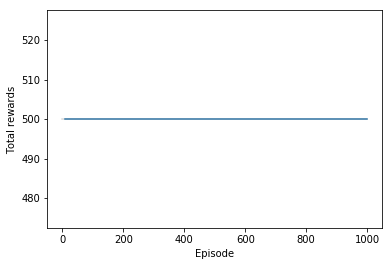

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

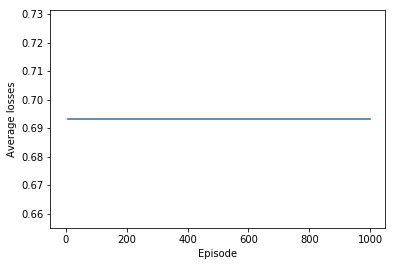

In [24]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn2.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.